In [162]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
# from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import scipy.interpolate as interp


<AxesSubplot:>

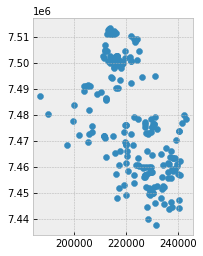

In [163]:
path = os.getcwd() + '\Dados vetoriais\Pontos amostrais_Piracicaba\Dados_227pts_original_06_03_2021.shp'
pontos_pira = gpd.read_file(path)
pontos_pira.plot()

<AxesSubplot:>

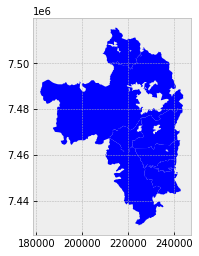

In [164]:
path2 = os.getcwd()+ '\Dados vetoriais\Piracicaba\Perimetro_Piracicaba.shp'
perimetro_pira = gpd.read_file(path2)
perimetro_pira.plot()

In [165]:
x_pontos = pontos_pira["geometry"].x
y_pontos = pontos_pira["geometry"].y

coords_rain = [list(xy) for xy in zip(x_pontos, y_pontos)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = perimetro_pira.total_bounds

# Get list of rainfall "values"
argila = list(pontos_pira["Argila"])

# Create a copy of counties dataset
counties_dissolved = perimetro_pira.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [166]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [167]:
all_x = []
all_y = []
for ea in counties_dissolved.geometry:
    for ea2 in ea.geoms:
        all_x.append(ea2.exterior.coords.xy[0])
        all_y.append(ea2.exterior.coords.xy[1])

all_x = list(np.concatenate(all_x).flat)
all_y = list(np.concatenate(all_y).flat)

all_dots = [list(xy) for xy in zip(all_x, all_y)]

In [168]:
f_x = interp.NearestNDInterpolator(coords_rain, argila)
value_rain_test = f_x(all_x, all_y)

In [169]:
# Split data into testing and training sets
# coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, argila, test_size = 0.20, random_state = 42)
coords_rain_train = coords_rain
coords_rain_test = all_dots
value_rain_train = argila

In [170]:

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = perimetro_pira.crs)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = perimetro_pira.crs)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

<AxesSubplot:>

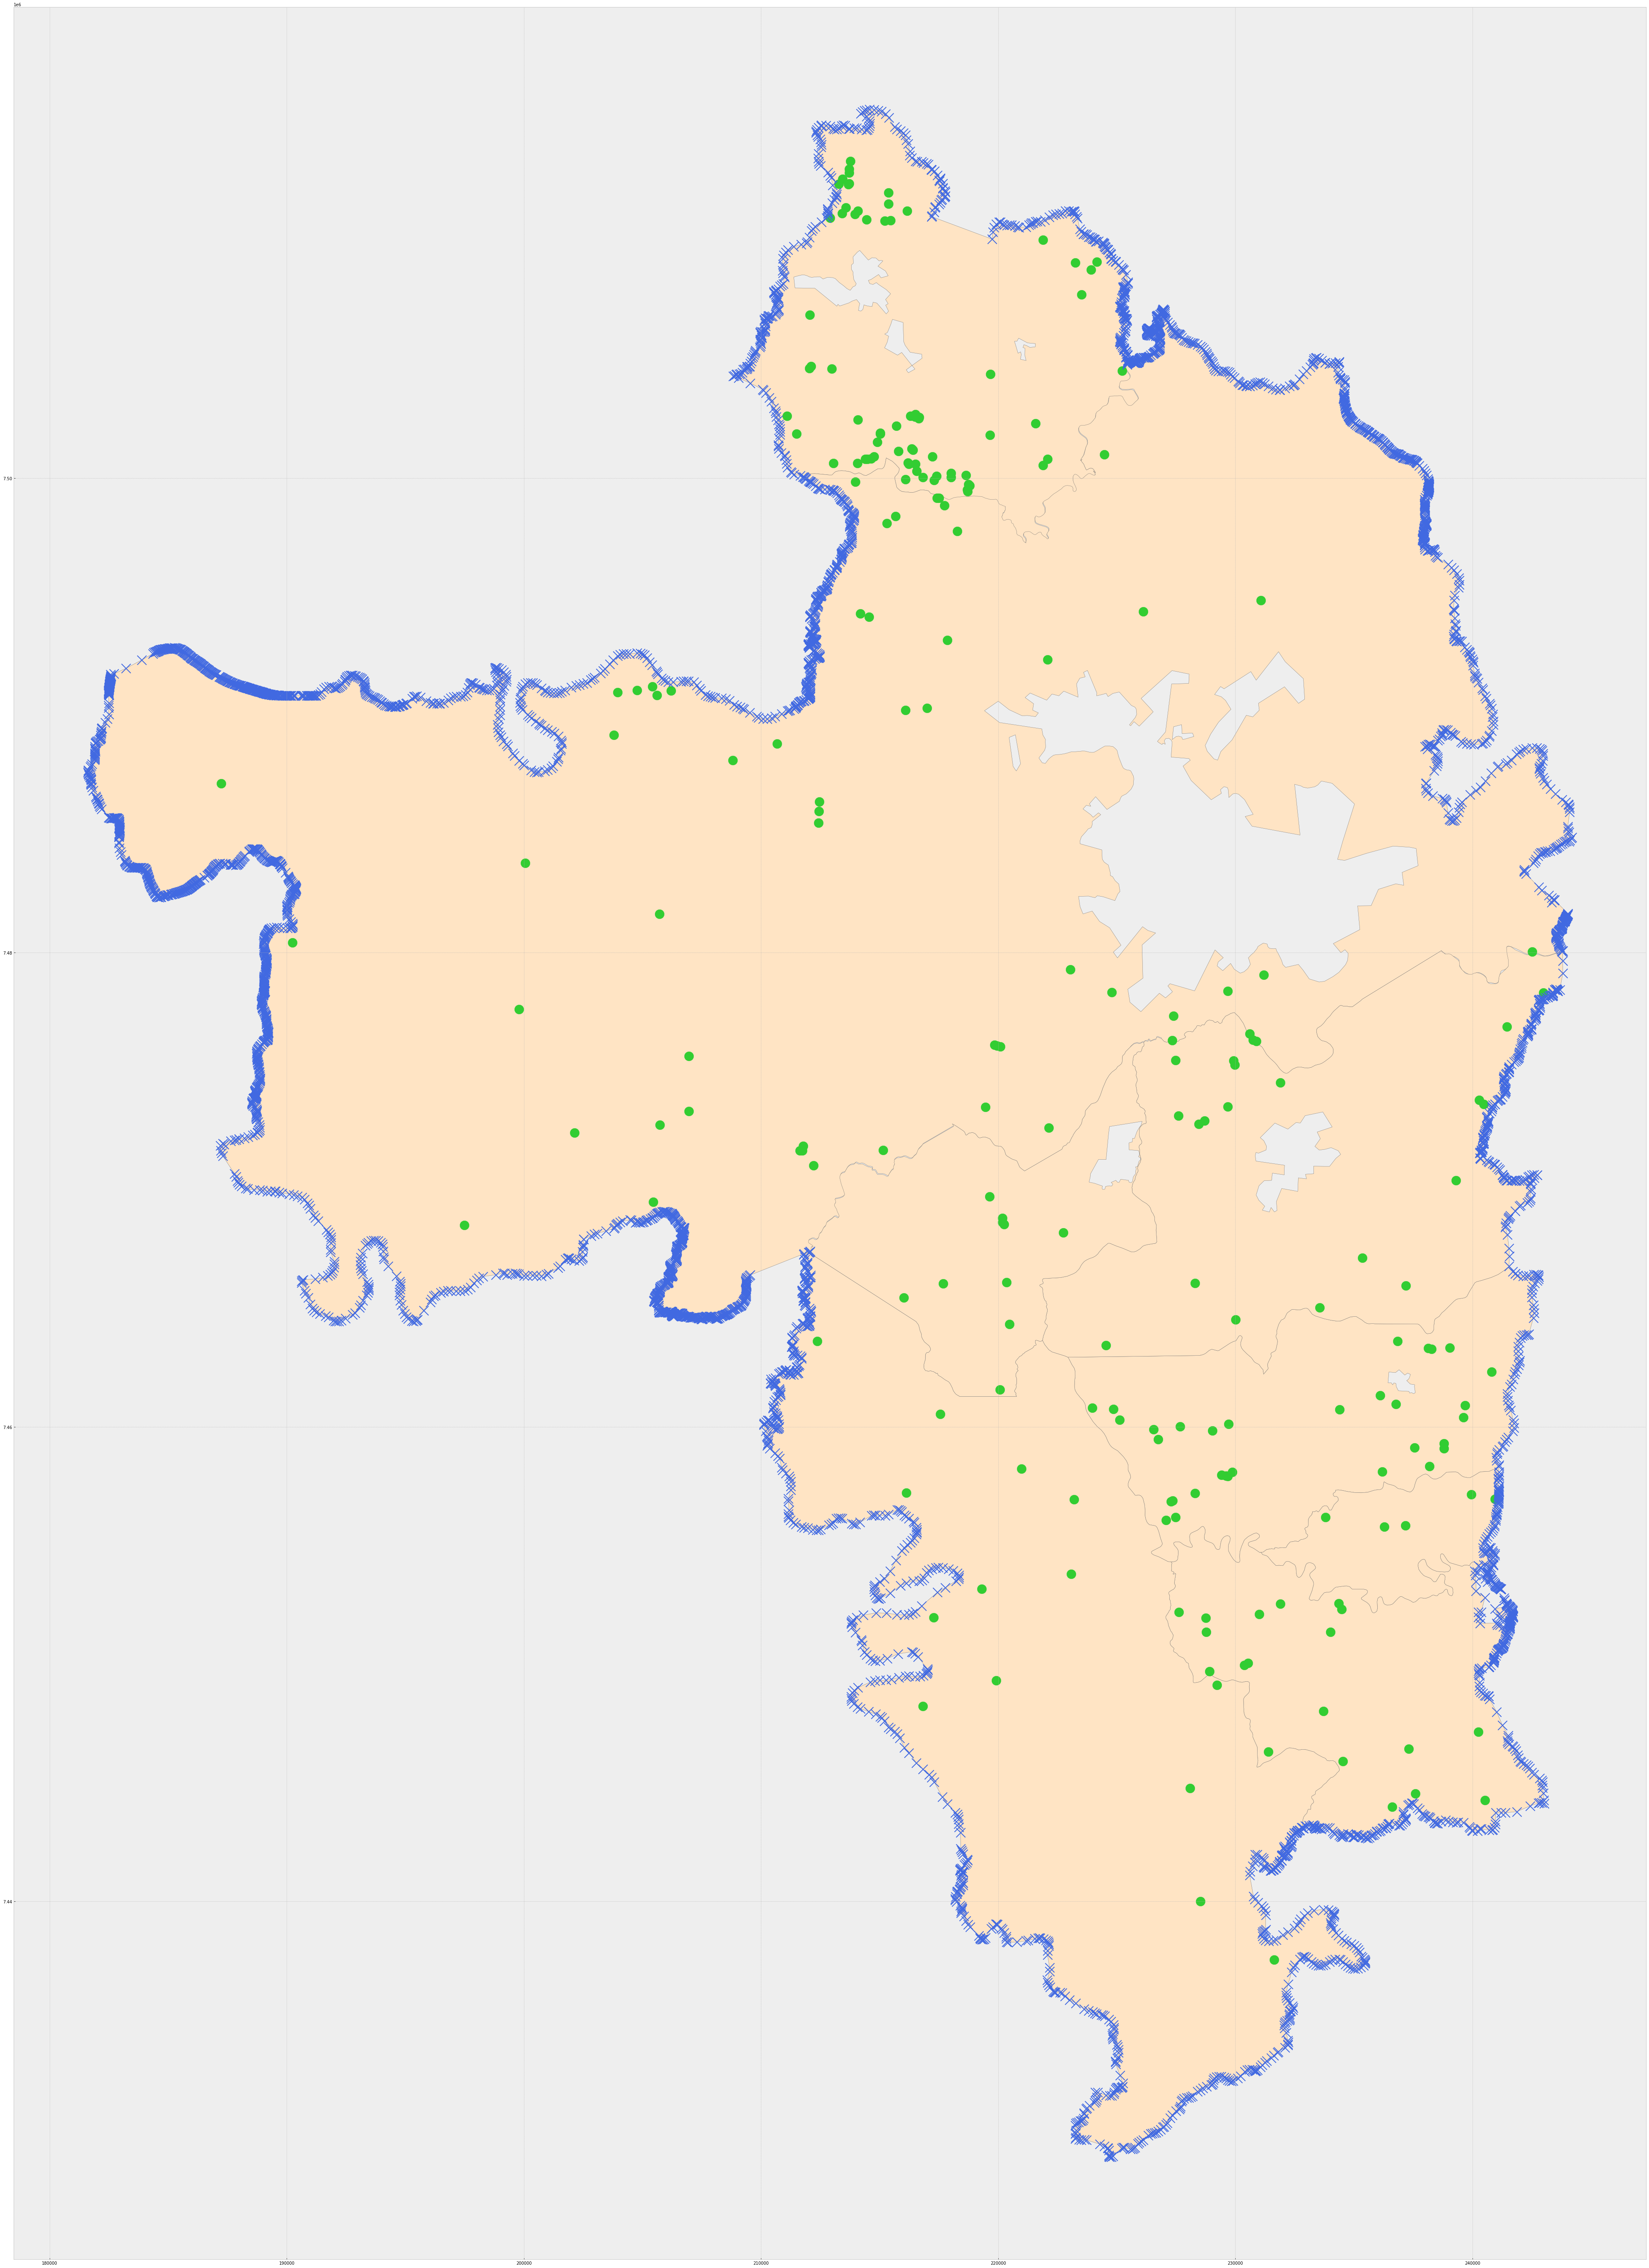

In [171]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (100, 100))

# Stylize plots
plt.style.use('bmh')

# Plot data
perimetro_pira.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 500)
rain_test_gdf.plot(ax = ax, marker = 'x', color = 'royalblue', markersize = 500)

In [172]:
# plt.pcolormesh(all_x, all_y, value_rain_test, shading='auto')
# plt.plot(x_pontos, y_pontos, "ok", label="input point")
# plt.legend()
# plt.colorbar()
# plt.axis("equal")
# plt.show()
